In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uncertainties as unc
from uncertainties import unumpy as unp
from scipy.optimize import curve_fit 


[0.92033323 0.00176606]
[1.32695271e-02 5.80327277e-05]
0.434+/-0.008
425+/-10


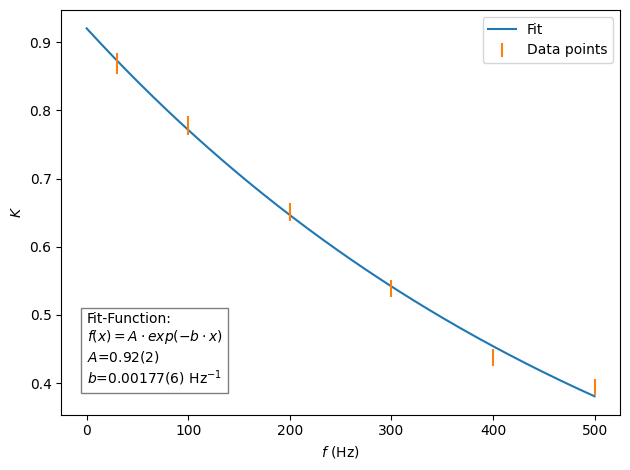

In [3]:
def contrast(Imax, Imin):
    return (Imax-Imin)/(Imax+Imin)
def exponential(x,a,b):
    return a*np.exp(-x*b)
contrast_file=pd.read_csv("FREQUENCY_CONTRAST.CSV")
contrast_file.head()
frequencies=unp.uarray(contrast_file["frequency(Hz)"], [2]*len(contrast_file["frequency(Hz)"]))
I_max=unp.uarray(contrast_file[" Imax(V)"], [0.1]*len(contrast_file[" Imax(V)"]))
I_min=unp.uarray(contrast_file[" Imin(V)"], [0.1]*len(contrast_file[" Imin(V)"]))
poptexp, pcovexp=curve_fit(exponential, unp.nominal_values(frequencies), unp.nominal_values(contrast(I_max,I_min)), \
    absolute_sigma='true',sigma=unp.std_devs(contrast(I_max,I_min)), p0=[0.9,0.002])
print(poptexp)
perrexp = np.sqrt(np.diag(pcovexp))
print(perrexp)

xfunkexp=np.linspace(0,500,1000)
plt.plot(xfunkexp, exponential(xfunkexp, *poptexp), label='Fit')
#plt.plot(xfunkexp, exponential(xfunkexp, 0.9,0.002), label='Fit')


plt.errorbar(unp.nominal_values(frequencies), unp.nominal_values(contrast(I_max, I_min)),yerr=unp.std_devs(contrast(I_max, I_min)), label='Data points', linestyle='none')
plt.xlabel('$f$ (Hz)')
plt.ylabel('$K$')
plt.text(0, 0.4, 'Fit-Function:\n$f(x)=A\cdot exp(-b \cdot x)$\n$A$=0.92(2)\n$b$=0.00177(6) Hz$^{-1}$', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.tight_layout()
plt.savefig('contrast_frequency_plot.pdf')
print(contrast(I_max,I_min)[0]/2)
bandwidth=-unp.log(contrast(I_max,I_min)[0]/(2*poptexp[0]))/poptexp[1]
print(bandwidth)

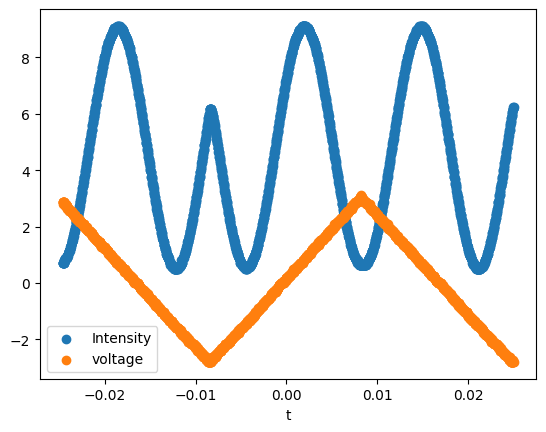

In [2]:
#time=pd.read_csv('F0000CH1.CSV', skiprows=18, usecols=[3])
#intensity=pd.read_csv('F0000CH1.CSV', skiprows=18, usecols=[4])
#voltage=pd.read_csv('F0000CH2.CSV', skiprows=18, usecols=[4])
data_ch1=pd.read_csv('data/ALL0000/F0000CH1.CSV', skiprows=18)
data_ch2=pd.read_csv('data/ALL0000/F0000CH2.CSV', skiprows=18)
time = data_ch1.iloc[:,3 ].values
intensity=data_ch1.iloc[:,4].values
voltage=data_ch2.iloc[:,4].values


plt.scatter(time, intensity, label='Intensity')
plt.scatter(time, voltage, label='voltage')
plt.xlabel('t')
plt.legend()
plt.show()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,-00.024640000000,0.72000,Unnamed: 5
0,NaN,NaN,NaN,-0.02462,0.72,NaN
1,NaN,NaN,NaN,-0.02460,0.72,NaN
2,NaN,NaN,NaN,-0.02458,0.72,NaN
3,NaN,NaN,NaN,-0.02456,0.72,NaN
4,NaN,NaN,NaN,-0.02454,0.72,NaN
...,...,...,...,...,...,...
2476,NaN,NaN,NaN,0.02490,6.16,NaN
2477,NaN,NaN,NaN,0.02492,6.16,NaN
2478,NaN,NaN,NaN,0.02494,6.24,NaN
2479,NaN,NaN,NaN,0.02496,6.16,NaN


In [11]:
arg_min=np.argmin(voltage)
arg_max=np.argmax(voltage)
#print(time[arg_min], time[arg_max])
print(arg_max, arg_min)
#print(voltage[arg_min])#
print(time[arg_min],time[arg_max] )

voltage_period=voltage[arg_min:arg_max+1]
intensity_period=intensity[arg_min:arg_max+1]

1640 800
-0.00862 0.00818


In [4]:
# Suchen im Bereich nach dem ersten Minimum bzw. Maximum
min_index_2 = np.argmin(voltage[arg_min+1:]) + arg_min + 1
#max_index_2 = np.argmax(voltage[arg_max+1:]) + arg_max + 1

# Intervall zwischen dem zweiten Minimum und zweiten Maximum bestimmen
interval = time[arg_max:min_index_2+1]
print(interval)

[]


In [5]:


def transmission(x,A,phi,b, Vpi):
    return A*np.cos(phi-x*np.pi/(2*Vpi))**2+b

popt, pcov=curve_fit(transmission, voltage_period, intensity_period, absolute_sigma='false', p0=[9.3,0.6,0.1,2.25 ])

#print(popt)
#print(pcov)

perr = np.sqrt(np.diag(pcov))
xfunk=np.linspace(np.min(voltage_period), np.max(voltage_period), 1000)
print(popt)
print(perr)

[8.50059462 0.59248669 0.58859013 2.24032995]
[0.10204273 0.00578985 0.05888163 0.01009547]


[8.50059462 0.59248669 0.58859013 2.24032995]


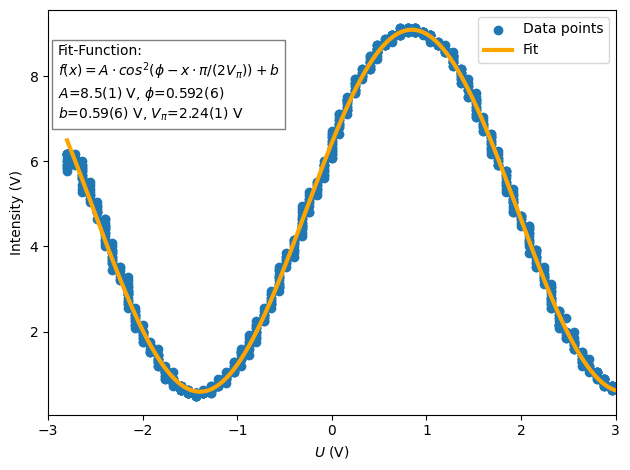

In [6]:
plt.scatter(voltage_period, intensity_period, label='Data points')
plt.plot(xfunk, transmission(xfunk, *popt), color='orange' , label='Fit', linewidth=3)
plt.ylabel('Intensity (V)')
plt.xlabel('$U$ (V)')
plt.legend()
plt.text(-2.9, 7, 'Fit-Function:\n$f(x)=A \cdot cos^2(\phi-x \cdot \pi/(2V_{\pi}))+b$\n$A$=8.5(1) V, $\phi$=0.592(6)\n$b$=0.59(6) V, $V_{\pi}$=2.24(1) V', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
plt.xlim(-3,3)
plt.tight_layout()
plt.savefig("voltage_intensity_pi.pdf")
print(popt)

In [17]:
lam = 633e-9
d = 1.8e-3
L = 25e-3
d*lam/(L*popt[3]*100)

2.0343431962413166e-10

In [9]:
def voltage_pi(File1, File2):
    data_ch1=pd.read_csv(File1, skiprows=18)
    data_ch2=pd.read_csv(File2, skiprows=18)
    time = data_ch1.iloc[:,3 ].values
    intensity=data_ch1.iloc[:,4].values
    voltage=data_ch2.iloc[:,4].values
    arg_min=np.argmin(voltage)
    arg_max=np.argmax(voltage)
    voltage_period=voltage[arg_min:arg_max+1]
    intensity_period=intensity[arg_min:arg_max+1]
    popt, pcov=curve_fit(transmission, voltage_period, intensity_period, absolute_sigma='false', p0=[9.3,0.6,0.1,2.25 ])
    perr = np.sqrt(np.diag(pcov))
    #plt.scatter(voltage_period, intensity_period, label='Data points')
    #plt.plot(xfunk, transmission(xfunk, *popt), color='orange' , label='Fit', linewidth=3)
    #plt.ylabel('Intensity (V)')
    #plt.xlabel('$U$ (V)')
    #plt.legend()
    #plt.text(-2.9, 7, 'Fit-Function:\n$f(x)=A \cdot cos^2(\phi-x \cdot \pi/(2V_{\pi}))+b$\n$A$=8.5(1) V, $\phi$=0.592(6)\n$b$=0.59(6) V, $V_{\pi}$=2.24(1) V', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    #plt.xlim(-3,3)
    #plt.tight_layout()
    #plt.show()
    return popt[3]

In [27]:
volt_pi1=voltage_pi("F0000CH1.CSV", "F0000CH2.CSV")
volt_pi2=voltage_pi("F0001CH1.CSV", "F0001CH2.CSV")
volt_pi3=voltage_pi("F0002CH1.CSV", "F0002CH2.CSV")
#print(unp.nominal_values(volt_pi1))
volts_pi=[volt_pi1, volt_pi2, volt_pi3]
print(volts_pi)

volt_pi_mean=np.mean(volts_pi)
volt_pi_dev=np.std(volts_pi)
print(volt_pi_mean)
print(volt_pi_dev)
#volt_Pi_mean=np.mean(unp.nominal_values(volt_pi1), unp.nominal_values(volt_pi2), unp.nominal_values(volt_pi3))
#volt_Pi_dev=np.mean(volt_pi1, volt_pi2, volt_pi3)
#print(volt_Pi_mean, volt_Pi_dev)
volt_pi_end=unc.ufloat(volt_pi_mean, volt_pi_dev)
print("hallo",volt_pi_end)
d=unc.ufloat(0.18,0.01)
l=unc.ufloat(2.455, 0.01)
lambda0=6.33e-05
factor=lambda0*d/(volt_pi_end*l*100)
print(factor)

[2.2403299544019446, 2.236255867558747, 2.2332237679544065]
2.236603196638366
0.0029114657905089
hallo 2.2366+/-0.0029
(2.08+/-0.12)e-08


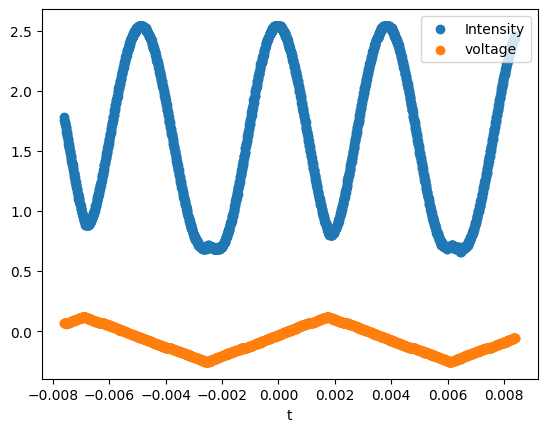

In [12]:
data_ch1=pd.read_csv('TEK00000_C.CSV', skiprows=16)
#data_ch2=pd.read_csv('F0000CH2.CSV', skiprows=18)
time = data_ch1.iloc[:,0 ].values
intensity=data_ch1.iloc[:,1].values
voltage=data_ch1.iloc[:,2].values


plt.scatter(time, intensity, label='Intensity')
plt.scatter(time, voltage, label='voltage')
plt.xlabel('t')
plt.legend()
plt.show()

77 618
1999
1999
[]
[]
[ 1.79411353 -0.3668066   0.70275808  0.19306747]
[0.0698469  0.02286382 0.06056137 0.00734702]
[ 1.79411353 -0.3668066   0.70275808  0.19306747]


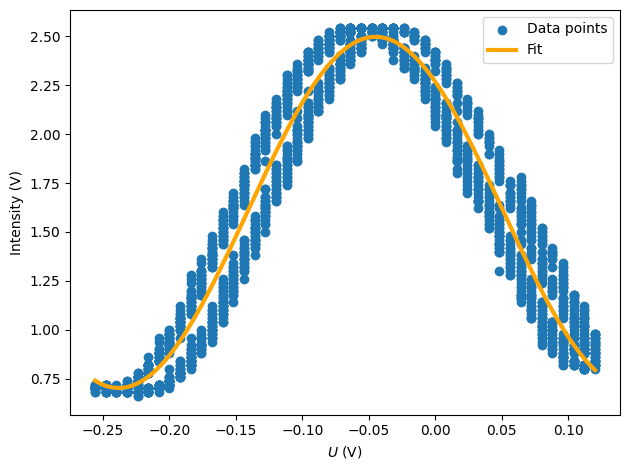

In [22]:
arg_min=np.argmin(voltage)
arg_max=np.argmax(voltage)
#print(time[arg_min], time[arg_max])
print(arg_max, arg_min)
#print(voltage[arg_min])#
#print(time[arg_min],time[arg_max] )
print(len(voltage))
print(len(intensity))
voltage_period=voltage[arg_min:arg_max+1]
intensity_period=intensity[arg_min:arg_max+1]
print(voltage_period)
print(intensity_period)
popt, pcov=curve_fit(transmission, voltage, intensity, absolute_sigma='false', p0=[9.3,0.6,0.1,2.25 ])

#print(popt)
#print(pcov)

perr = np.sqrt(np.diag(pcov))
xfunk=np.linspace(np.min(voltage), np.max(voltage), 1000)
print(popt)
print(perr)

plt.scatter(voltage, intensity, label='Data points')
plt.plot(xfunk, transmission(xfunk, *popt), color='orange' , label='Fit', linewidth=3)
plt.ylabel('Intensity (V)')
plt.xlabel('$U$ (V)')
plt.legend()
#plt.text(-2.9, 7, 'Fit-Function:\n$f(x)=A \cdot cos^2(\phi-x \cdot \pi/(2V_{\pi}))+b$\n$A$=8.5(1) V, $\phi$=0.592(6)\n$b$=0.59(6) V, $V_{\pi}$=2.24(1) V', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
#plt.xlim(-3,3)
plt.tight_layout()
plt.savefig("voltage_intensity_pi.pdf")
print(popt)